# Analyse de Sentiment avec Bag-of-Words

Romain BLANCHOT - 


In this analysis, we will use the Bag-of-Words approach to analyze sentiments in Amazon reviews.
We will:
1. Load and preprocess the data
2. Create a Bag-of-Words model
3. Train a classifier
4. Evaluate model performance

In [1]:
import os
import kagglehub


path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Path to dataset files:", path)

if os.path.exists(path):
    files = os.listdir(path)
    print("Dir Content : ", files)
else:
    raise FileNotFoundError("The path does not exist")
    

/home/talleyrand/anaconda3/envs/sentiment-bow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/talleyrand/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7
Dir Content :  ['train.ft.txt.bz2', 'test.ft.txt.bz2']


In [2]:
import bz2
import pandas as pd


def load_dataset(file_path, max_lines = 10000):
    texts = []
    labels = []
    
    with bz2.open(file_path, mode="rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            parts = line.split(" ", 1)
            if len(parts) != 2:
                continue
            label, text = parts
            labels.append(label.replace("__label__", ""))
            texts.append(text)
    
    return pd.DataFrame({"label": labels, "text": texts})

df = load_dataset(os.path.join(path, "train.ft.txt.bz2"), max_lines=10000)

In [3]:

import re 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocessor(text):
    text = re.sub(r"[^\w\s]", "", text) # because we want to suppress punctuation
    tokens = text.lower().split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)

vectorizer = CountVectorizer(
    input='content',
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    preprocessor=preprocessor,
    ngram_range=(1, 2),
    max_features=3000, # maximum dictionary size
    max_df=0.95,
    min_df=2
)

X = vectorizer.fit_transform(df["text"])  
print(type(X))
# X is a sparse matrix, which uses less memory than a dense matrix.
# A sparse vector is a single row/column from this matrix, also sparse in content, but not a different storage format.

print(f"BoW shape: {X.shape}")  # (10000, 3000) 
print("Features:", vectorizer.get_feature_names_out()[:30])


/home/talleyrand/anaconda3/envs/sentiment-bow/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


<class 'scipy.sparse._csr.csr_matrix'>
BoW shape: (10000, 3000)
Features: ['10' '10 minute' '10 year' '100' '100 year' '1000' '11' '12' '13' '14'
 '15' '15 minute' '16' '17' '18' '1984' '1st' '20' '20 year' '200' '2000'
 '20th' '20th century' '23' '24' '25' '2nd' '30' '30 minute' '30 year']


In [4]:
from sklearn.model_selection import train_test_split

# Split into X (vectorized text) and y (label)
y = df["label"].astype(int)  # Convert to integer

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Logistic Regression Accuracy: 0.8300
              precision    recall  f1-score   support

           1       0.83      0.84      0.84      1037
           2       0.83      0.82      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Confusion matrix:
[[874 163]
 [177 786]]

Multinomial NB Accuracy: 0.8245
              precision    recall  f1-score   support

           1       0.83      0.83      0.83      1037
           2       0.81      0.82      0.82       963

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

Confusion matrix:
[[856 181]
 [170 793]]

SGBDClassifier Accuracy: 0.8105
              precision    recall  f1-score   support

           1       0.81      0.82      0.82      1037
           2       0.81      0.80      0.80       9

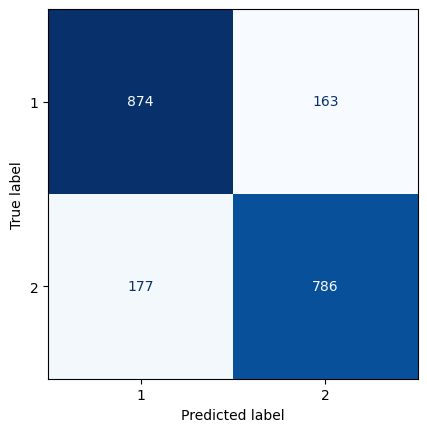

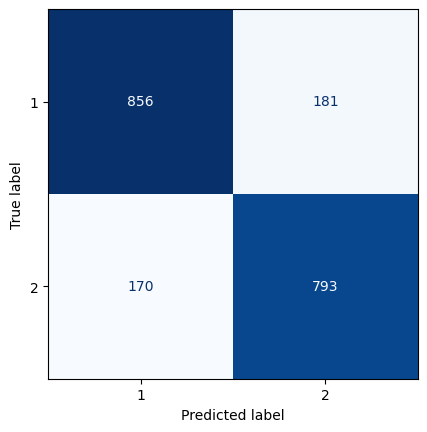

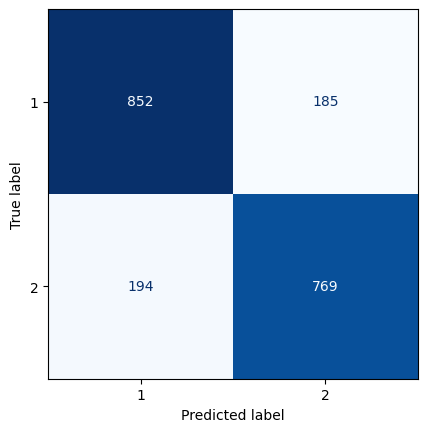

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    "SGBDClassifier": SGDClassifier(max_iter=1000, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)

    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", colorbar=False)


In [6]:
def predict_sentiment(comment: str, model, model_name: str):
    comment_clean = preprocessor(comment)
    vector = vectorizer.transform([comment_clean])
    prediction = model.predict(vector)[0]
    sentiment = "positive" if prediction == 2 else "negative"

    print(f"\nModel: {model_name}")
    print(f"Comment: \"{comment}\"")
    print(f"→ Predicted sentiment: {sentiment} (label = {prediction})")


In [7]:
test_comments = [
    "This product was terrible and broke in two days.",
    "Absolutely love it, highly recommend this product."
]

for name, model in models.items():
    for comment in test_comments:
        predict_sentiment(comment, model, name)



Model: Logistic Regression
Comment: "This product was terrible and broke in two days."
→ Predicted sentiment: negative (label = 1)

Model: Logistic Regression
Comment: "Absolutely love it, highly recommend this product."
→ Predicted sentiment: positive (label = 2)

Model: Multinomial NB
Comment: "This product was terrible and broke in two days."
→ Predicted sentiment: negative (label = 1)

Model: Multinomial NB
Comment: "Absolutely love it, highly recommend this product."
→ Predicted sentiment: positive (label = 2)

Model: SGBDClassifier
Comment: "This product was terrible and broke in two days."
→ Predicted sentiment: negative (label = 1)

Model: SGBDClassifier
Comment: "Absolutely love it, highly recommend this product."
→ Predicted sentiment: positive (label = 2)
